# Registration PET and relevance maps to MRI and MNI152 template

In [28]:
# import libraries
import pandas as pd
import numpy as np
import nibabel as nib
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, concatenate
from tensorflow import keras 
import keract
from keract import get_activations
import matplotlib.pyplot as plt

In [29]:
import os, fnmatch, glob

In [30]:
import scipy
import tensorflow as tf

In [31]:
import itk 

import matplotlib.pyplot as plt

# %matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import ants
import pickle

In [32]:
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import math

In [33]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS"] = "8"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [34]:
# path to files
date = '20_10_22'

In [35]:
len(glob.glob(date+'/*model*.h5'))

23

In [36]:
# load the best model from training
if len(glob.glob(date+'/*model*.h5'))>2:
    hist=np.load(date+'/abeta_history_'+date+'.npy',allow_pickle='TRUE').item()
    best_model_number = np.where(hist['val_loss']==np.min(hist['val_loss']))[0].tolist()[0]
    np.where(hist['val_loss']==np.min(hist['val_loss']))[0].astype(int)[0]

    print(glob.glob(date+'/*')[best_model_number])
    best_model_name = glob.glob(date+'/*')[best_model_number]
    saved_model = keras.models.load_model( best_model_name)
else:
    saved_model = keras.models.load_model(date+'/best_model_'+date+'.h5')

20_10_22/model_08-0.12_20_10_22.h5


In [37]:
meta_full = pd.read_csv('/csc/epitkane/home/atagmazi/AD_DL_ADNI/metafile_completing/metafile_completed_adni_all_04_10_2022.csv')
abeta_perm = pd.read_csv(date+'/abeta_info_'+date+'.csv')

In [38]:
meta_full['year'] = ''
for i in range(meta_full.shape[0]):
    meta_full['year'][i] = meta_full['Study.Date'].values[i].split('/')[2]

In [39]:
meta_full.shape

(31431, 28)

In [40]:
abeta_perm['year'] = ''
for i in range(abeta_perm.shape[0]):
    abeta_perm['year'][i] = abeta_perm['Study.Date'].values[i].split('/')[2]

In [41]:
abeta_perm.shape

(1870, 29)

In [42]:

train_size = 0.8
train_end = int(len(abeta_perm)*train_size)
abeta_train = abeta_perm.loc[:train_end]
abeta_test = abeta_perm.loc[train_end:]



In [45]:
# change activation layers from ReLu to guided ReLu (replace negative gradients with zero)
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
    return tf.nn.relu(x), grad


layer_dict = [layer for layer in saved_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu
        print("changed")
        



changed
changed
changed
changed
changed
changed
changed
changed
changed


In [146]:
saved_model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 96 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 77, 77, 47, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 77, 77, 47, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 77, 77, 47, 6 0           bn_conv1[0][0]                   
_____________________________________________________________________________________________

In [22]:
img=nib.load('/csc/epitkane/data/ADNI/AD_DL_03_11_2021/ADNI_002_S_0295_PT_AV45_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20110616145834650_51_S111274_I240520.nii')
image = img.get_fdata()

In [23]:
image = image.reshape([1,160, 160, 96, 1])

In [149]:
# example of relevance map calculation
input_img = tf.convert_to_tensor(image[:1], dtype = 'float32')
with tf.GradientTape() as tape:
    tape.watch(input_img)
    predicted_csf = saved_model(input_img)
grads = tape.gradient(predicted_csf, input_img)

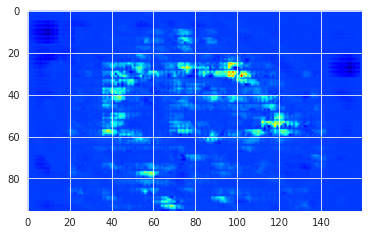

In [25]:
plt.imshow(np.rot90(grads[0][60,:,:]), cmap = 'jet')

In [26]:
# mni https://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009
mni_t1 = ants.image_read('/csc/epitkane/home/atagmazi/Downloads/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii')
brain_mask = ants.image_read('/csc/epitkane/home/atagmazi/Downloads/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nii')



## Automatization, require enough computational power

In [27]:
id = abeta_perm['Image_id'].unique()
wrap_grad_all = dict()
wrap_pet_all = dict()

In [40]:
abeta_test.shape[0]

374

In [41]:
id[15]

'I194763'

In [139]:
suc = 0 
er = 0
for i in range(abeta_perm.shape[0]):
    #finding the matching MRI and PET scans
    pet_id = abeta_perm[abeta_perm['Image_id']==id[i]] # all data
    mri_data = meta_full.copy()
    mri_data = mri_data[mri_data['RID'].isin(pet_id['RID'])]
    mri_data = mri_data.loc[(mri_data['Image_id']==pet_id['Image_id'].values[0]) |
                            ((mri_data['Modality'].isin(['MRI'])) & (mri_data['Age'].values == pet_id['Age'].values[0]))|
                            ((mri_data['Modality'].isin(['MRI'])) & (mri_data['VISITCODE'].isin(pet_id['VISITCODE'])))|
                       ((mri_data['Modality'].isin(['MRI'])) & (mri_data['year'].values == pet_id['year'].values[0]))]
    
    
    if mri_data.shape[0]>1: #1 because one of the line is for PET scan
        if (mri_data['Description'].values == ' MPRAGE').any():
            mri=ants.image_read(mri_data['PATH'].loc[mri_data['Description'] == ' MPRAGE'].values[0])
            if np.sum(np.isnan(mri.numpy())) > 0:
                mri=ants.image_read(mri_data['PATH'].loc[mri_data['Modality'] == 'MRI'].values[0])
                if np.sum(np.isnan(mri.numpy())) > 0:
                    er += 1
                    print(str(i) + ' '+ pet_id['Image_id']+' error')
                    continue
        else:
            mri=ants.image_read(mri_data['PATH'].loc[mri_data['Modality'] == 'MRI'].values[0])
            if np.sum(np.isnan(mri.numpy())) > 0:
                er += 1
                print(str(i) + ' '+ pet_id['Image_id']+' error')
                continue
    
  
        # co-registration to MNI152 template    
        pet = ants.image_read(pet_id['PATH'].values[0])

        pet_numpy=pet.numpy()
    
        image = pet_numpy.reshape([1,160, 160, 96, 1])
        input_img = tf.convert_to_tensor(image[:1], dtype = 'float32')
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            predicted_csf = saved_model(input_img)
        grads = tape.gradient(predicted_csf, input_img)
    
        grad = ants.from_numpy(np.array(grads).reshape([160, 160, 96]),origin=pet.origin, spacing=pet.spacing, 
                       direction=pet.direction)
    
        pet_to_mri = ants.registration(fixed=mri, moving=pet, type_of_transform = 'SyN')
    
        mri_to_mni = ants.registration(fixed=mni_t1, moving=mri, type_of_transform = 'SyN')
    
        transf_list = mri_to_mni[ 'fwdtransforms'] + pet_to_mri[ 'fwdtransforms']
    
        wrap_grad = ants.apply_transforms(fixed = mni_t1, moving = grad,
                             transformlist=transf_list)
        wrap_grad_all[pet_id['Image_id'].values[0]] = wrap_grad.numpy()
        
        wrap_pet = ants.apply_transforms(fixed = mni_t1, moving = pet,
                             transformlist=transf_list)
        wrap_pet_all[pet_id['Image_id'].values[0]] = wrap_pet.numpy()
        
        suc += 1
        print(str(i) + ' '+ pet_id['Image_id']+' done')
        
        #remove temporaly files from /tmp directory
        for filename in fnmatch.filter(os.listdir('/tmp/'), 'tmp*Warp.nii.gz')+fnmatch.filter(os.listdir('/tmp/'), '*Affine.mat'):
            os.remove(os.path.join('/tmp/', filename))
    else: 
        er += 1
        print(str(i) + ' '+ pet_id['Image_id']+' error')
    #print(mri_data)

0    0 I323924 done
Name: Image_id, dtype: object
1    1 I364745 error
Name: Image_id, dtype: object
2    2 I641244 done
Name: Image_id, dtype: object
3    3 I1208983 error
Name: Image_id, dtype: object
4    4 I269770 done
Name: Image_id, dtype: object
5    5 I1054691 error
Name: Image_id, dtype: object
6    6 I421684 done
Name: Image_id, dtype: object
7    7 I316555 done
Name: Image_id, dtype: object
8    8 I1021704 error
Name: Image_id, dtype: object
9    9 I399239 error
Name: Image_id, dtype: object
10    10 I858357 done
Name: Image_id, dtype: object
11    11 I337259 done
Name: Image_id, dtype: object
12    12 I495336 done
Name: Image_id, dtype: object
13    13 I247735 done
Name: Image_id, dtype: object
14    14 I1057212 error
Name: Image_id, dtype: object


IndexError: index 0 is out of bounds for axis 0 with size 0

In [50]:
# save files with registered pet and relevance maps
with open('wrap_grad_all.pkl', 'wb') as f:
    pickle.dump(wrap_grad_all, f)
    
with open('wrap_pet_all.pkl', 'wb') as f:
    pickle.dump(wrap_pet_all, f)


In [51]:
#srun --time=16:00:00 --mem=20G --cpus-per-task=8 python abeta_registration.py > reg_out.txt 2> reg_log.txt

print('DONE')

DONE
